 ## net_sim_mp.ipynb

This notebook is a template to run multiprocess simulations using the ei_network class.  

The particular network being build and simulated under different variations is that from step1.ipynb part 2.


By `Sergio Verduzco`  
June 2018

In [1]:
# import the ei_network class and draculab
%cd ..
from ei_network import *
from pathos.multiprocessing import ProcessingPool
import sys

/home/z/projects/draculab


In [2]:
# This is the name of the file where logging will happen
log_file = "./logs/mp_net" + time.strftime("_%m-%d-%y.txt")

In [3]:
%%capture capt 
# logging draculab version used for this session
print('#======================================================')
print('#             | Latest git commit: |')
print('#====================================================== \n#', end=' ')
!git log -1 --oneline --color=never

In [4]:
# Write the output of the cell above in the simulation log
f = open(log_file, mode='a')
f.write(capt.stdout)
f.close()

In [ ]:
#~~~~~~~~~~~~ mp_net_runner object specification ~~~~~~~~~~~~

class mp_net_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self):
        """ Set parameter values and build the networks. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            input_type : The 'input_config' method, called by 'run_all', will specify the inputs sent by I1 and I2 in each
                         network, by creating custop inp_pats and inp_funcs methods. The value of input_type[i] is used in
                         input_config to know which input type will be used in network 'i'.
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        
        """
        self.name = 'sig_test1'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 12  # one per network is good
        self.n_nets = 12
        self.n_pres = [264]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.input_type = [1]*self.n_nets # specifies the values input_config assigns to inp_pats and inp_funcs
                                          # currently it's 0 for sharpening, and 1 for non-sharpening
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        #F = open("/media/z/DATA/pickles/mp_net_runner_prototype.pkl", 'rb')
        #dill_obj = dill.load(F)
        #self.nets = dill_obj.nets
        
        #layers =  ['L', 'shrp','I1', 'I2']  # L is the layer, shrp is for the sharpen port, I1,I2 are the input layers
        layers =  ['L','I1', 'I2']  # L is the layer, shrp is for the sharpen port, I1,I2 are the input layers
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('It is testing networks of sigmoidal units. The input layers now send projections with')
            net.annotate('random spatial arrangements, rather than the criss-cross connectivity.')
            #net.annotate('10x10 in L.e and 5x5 in L.i without compensating. In here the radius of connection')
            #net.annotate('is increased, the standard tau_scale is decreased, and in the variations to the homeostatic ')
        #----------------------------------
            L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
        #----------------------------------
            L.annotate("Configuration of units in layer L.")
            L.set_param('e_pars', 'type', unit_types.sigmoidal)
            L.set_param('e_pars', 'slope_min', 1.7)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', .0)
            L.set_param('e_pars', 'thresh_wid', 0.5)
            L.set_param('e_pars', 'n_ports', 1)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.45, 0.45], 'slopes' : 4, 'threshs' : 0.2})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .002)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .002)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 1)
        #----------------------------------
            L.annotate("Adjusting size of e,i groups.")
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 5)
            L.set_param('i_geom', 'columns', 5)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            L.annotate("Compensating for the ratio of excitatory to inhibitory units.")
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.2, 'high' : -.2}})            
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
        #----------------------------------
            L.annotate("Setting input parameters")
            L.set_param('x_geom', 'rows', 0) # no input units in layer L
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 0)
            L.set_param('ie_syn', 'inp_ports', 0)
        #----------------------------------
            L.annotate("Using Oja input synapses")
            L.set_param('xe_syn', 'type', synapse_types.oja)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.oja)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 2.)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./20.)
            L.set_param('e_pars', 'des_act', 0.4)
        #----------------------------------
            L.annotate("Using anti_cov_pre EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.anticov_pre)
            L.set_param('ei_syn', 'lrate', .02)
        #----------------------------------
            I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 8)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 8)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
        #----------------------------------
        # Add interlayer connections
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
         #----------------------------------        
        # Configure interlayer connections
            net.set_param('I1x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Le_conn', 'number_of_connections', 2)
            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', False)
            net.set_param('I1x_Le_syn', 'inp_ports', 0)
            net.set_param('I1x_Le_syn', 'type', synapse_types.static)
            net.set_param('I1x_Le_syn', 'lrate', 1./100.)

            net.set_param('I1x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Li_conn', 'number_of_connections', 2)
            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', False)

            net.set_param('I2x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Le_conn', 'number_of_connections', 2)
            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I2x_Le_conn', 'edge_wrap', False)
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_syn', 'inp_ports', 0)
            net.set_param('I2x_Le_syn', 'type', synapse_types.static)
            net.set_param('I2x_Le_syn', 'lrate', 1./100.)

            net.set_param('I2x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Li_conn', 'number_of_connections', 2)
            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', False)
            
        # Now adjust networks individually
        ### network 0 is the baseline
        ### network 1
        n = 1
        L = self.nets[n].layers['L']
        L.annotate(">>> sq_hebbsnorm input synapses")
        self.nets[n].set_param('I1x_Le_syn', 'type', synapse_types.sq_hebbsnorm)
        self.nets[n].set_param('I1x_Le_syn', 'lrate', 1./100.)
        self.nets[n].set_param('I1x_Le_syn', 'omega', 1.5)
        self.nets[n].set_param('I2x_Le_syn', 'type', synapse_types.sq_hebbsnorm)
        self.nets[n].set_param('I2x_Le_syn', 'lrate', 1./100.)
        self.nets[n].set_param('I2x_Le_syn', 'omega', 1.5)
        ### network 2
        n = 2
        L = self.nets[n].layers['L']
        L.annotate(">>> Oja input synapses")
        self.nets[n].set_param('I1x_Le_syn', 'type', synapse_types.oja)
        self.nets[n].set_param('I2x_Le_syn', 'type', synapse_types.oja)
        ### network 3
        n = 3
        L = self.nets[n].layers['L']
        L.annotate(">>> BCM input synapses")
        self.nets[n].set_param('I1x_Le_syn', 'type', synapse_types.bcm)
        self.nets[n].set_param('I2x_Le_syn', 'type', synapse_types.bcm)
        ### Network 4
        n = 4
        L = self.nets[n].layers['L']
        L.annotate(">>> sq_hebbsnorm input synapses, and very slow EE, IE plasticity")
        self.nets[n].set_param('I1x_Le_syn', 'type', synapse_types.sq_hebbsnorm)
        self.nets[n].set_param('I1x_Le_syn', 'lrate', 1./100.)
        self.nets[n].set_param('I1x_Le_syn', 'omega', 1.5)
        self.nets[n].set_param('I2x_Le_syn', 'type', synapse_types.sq_hebbsnorm)
        self.nets[n].set_param('I2x_Le_syn', 'lrate', 1./100.)
        self.nets[n].set_param('I2x_Le_syn', 'omega', 1.5)
        L.set_param('ee_syn', 'lrate', 1./2000.)
        L.set_param('ie_syn', 'lrate', 1./2000.)
        ### Network 5
        n = 5
        L = self.nets[n].layers['L']
        L.annotate("Removing EI plasticity")
        L.set_param('ei_syn', 'type', synapse_types.static)
        ### Network 6
        n = 6
        L = self.nets[n].layers['L']
        L.annotate("Removing IE plasticity")
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 7
        n = 7
        L = self.nets[n].layers['L']
        L.annotate("Removing EE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        ### Network 8
        n = 8
        L = self.nets[n].layers['L']
        L.annotate("Removing EI, IE plasticity")
        L.set_param('ei_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 9
        n = 9
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, EI plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ei_syn', 'type', synapse_types.static)
        ### Network 10
        n = 10
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, IE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 11
        n = 11
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, EI, IE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ei_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        
        self.build()
                      
            
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat0(self, pres, rows, columns, net_id, port=0, random=True):
    # The function that creates the input pattern at L.x
        if random:
            idx = np.random.randint(4)
        else:
            idx = pres % 4
        return (self.pat_arr0[idx, :], idx)
    
    def inp_pat1(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I1
        if random:
            if pres < 200:
                idx = np.random.randint(n_pat)
            else:
                idx = self.idx_list1[pres%len(self.idx_list1)]
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def inp_pat2(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I2
        if random:
            if pres < 200:
                idx = np.random.randint(n_pat)
            else:
                idx = self.idx_list2[pres%len(self.idx_list2)]
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def make_I1_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat1(pres, rows, columns, net_id, n_pat, random=rnd) 
    
    def make_I2_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat2(pres, rows, columns, net_id, n_pat, random=rnd)

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # patterns for L.x
        n_pat0 = 4  # number of input patterns
        self.pat_arr0 = np.zeros((4, 25)) # ei_runner.n['x'])) # array with all input patterns
        for row in range(5):
            for col in range(5):
                idx = 5*col + row
                if row == col or row+col == 4: # The X input pattern
                    self.pat_arr0[0,idx] = 1
                if row == 2 or col == 2:  # The + input pattern
                    self.pat_arr0[1,idx] = 1
                if row == 1 or row == 3:  # The = input pattern
                    self.pat_arr0[2,idx] = 1
                if col == 1 or col == 3:  # The || input pattern
                    self.pat_arr0[3,idx] = 1
        self.pat_arr0 = self.pat_arr0 / 5.
        
        self.idx_list1 = [] # list with indexes of permuted input patterns for I1
        self.idx_list2 = [] # list with indexes of permuted input patterns for I2
        
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            #shrp = net.layers['shrp']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units
            
            # preparing vectors with all the inputs in permuted order. Used by the inp_patX methods.
            i_nums = np.random.permutation(n_pat1*n_pat2)
            self.idx_list1 = [int(np.floor(n/n_pat2)) for n in i_nums]
            self.idx_list2 = [int(round(n%n_pat2)) for n in i_nums]
            
            if self.input_type[idx] == 0:  # for sharpening units
                shrp_inp_pat = lambda p, r, c, n : (1., 1)
                inp_pat_dic = { 'I1' : self.make_I1_inp(n_pat1, True), 
                                'I2' : self.make_I2_inp(n_pat2, True), 
                                'shrp' : shrp_inp_pat }
                inp_fun_dic = {'shrp' : self.set_shrp_fun }
            elif self.input_type[idx] == 1: # for non-sharpening units
                inp_pat_dic = { #'L' : self.inp_pat0,
                                'I1' : self.make_I1_inp(n_pat1, True), 
                                'I2' : self.make_I2_inp(n_pat2, True) } 
                inp_fun_dic = {}
            else:
                raise ValueError('Invalid input type for network ' + str(idx))
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)

    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base 
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of mp_net_runner object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(n_nets)]
            self.nets = pool.map(self.run_net, args)
            # you can run just a few nets for debugging purposes...
            #selected = [0, 1, 2] #, 1, 2, 3, 6, 8, 9, 10, 11, 12, 14, 15]
            #sel_nets = [self.nets[n] for n in selected]
            #args = [(n, self.n_pres[n]) for n in selected]
            #sel_nets = pool.map(self.run_net, args)
            #for i,n in enumerate(selected):
            #    self.nets[n] = sel_nets[i]
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
                                
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
%%capture runner
# capture the configuration of the mp_net_runner object
%history -l 1

In [ ]:
# Create an mp_net_runner object and simulate
## Create
mp_net_obj = mp_net_runner()
## Put the code that configures mp_net_runner in mp_net_obj.code
mp_net_obj.code = str(runner)
## Run
mp_net_obj.run_all(save=True, log=False, save_interv=10)

In [ ]:
# Simulation analysis
net_num = 1
ei_net = mp_net_obj.nets[net_num]
pats1 = ei_net.inp_hist['I1']
pats2 = ei_net.inp_hist['I2']
n_pat1 = ei_net.layers['I1'].n['x']
n_pat2 = ei_net.layers['I2'].n['x']
pres_time = mp_net_obj.pres_t[net_num]
n_pres = mp_net_obj.n_pres[net_num]
L = ei_net.layers['L']
inp_pat1 = mp_net_obj.make_I1_inp(n_pat1, False)
inp_pat2 = mp_net_obj.make_I2_inp(n_pat2, False)

## For each input presentation obtain the activity vector from layer L
ppat = int(round(pres_time/ei_net.net_params['min_delay'])) # number of data points per input pattern
pt = int(round((pres_time-0.2)/ei_net.net_params['min_delay'])) # data point where the vector will come from
e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
for pres in range(n_pres):
    for e_idx, idx in enumerate(L.e):
        e_pats[e_idx, pres] = ei_net.all_activs[idx, pres*ppat + pt]

# The ID of the input comes from the id's in pats1 and pats2, placed by inp_pat1 and inp_pat2 respectively.
pats = np.zeros(n_pat1*n_pat2)  # pats[n] is the number of times the pattern with ID 'n' appeared
n_pats = len(pats)
pres_pat = np.zeros(n_pres)  # pres_pat[n] is the ID of the pattern in presentation 'n'
for p in range(n_pres):
    p_id = n_pat2*pats1[p] + pats2[p] # the pattern ID 'flattens' all possible pairs of values
    pats[p_id] += 1
    pres_pat[p] = p_id
    
# plot the array of activity patterns
#%matplotlib inline
#ex_fig = plt.figure(figsize=(20,20))
#plt.imshow(e_pats)

# get the mean of output patterns corresponding to the same inputs
mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
for pres in range(n_pres):
    mean_out[:,int(pres_pat[pres])] += e_pats[:,pres]
    
for pat in range(n_pats):
    if pats[pat] > 1:
        mean_out[:, pat] = mean_out[:, pat]/ pats[pat]
        
# Obtain the angles between any two pairs of input patterns
# get all input patterns
all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
for p1 in range(n_pat1):
    for p2 in range(n_pat2):
        (all_inps[p1*n_pat2+p2, :n_pat1], _) = inp_pat1(p1, 1, 1, net_num)
        (all_inps[p1*n_pat2+p2, n_pat1:], _) = inp_pat2(p2, 1, 1, net_num)
        

# get matrices with dot products between pairs of patterns
inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
inp_norm2 = inp_norm*inp_norm
inp_dots = np.zeros((n_pats, n_pats))
out_dots = np.zeros((n_pats, n_pats))
for p1 in range(n_pats):
    for p2 in range(n_pats):
        inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
        if pats[p1] > 0 and pats[p2] > 0: # if the two input patterns were presented
                #pres_idx1 = np.argmin(abs(pres_pat - p1))  # index of presentation where you showed pattern 1
                #pres_idx2 = np.argmin(abs(pres_pat - p2))  # index of presentation where you showed pattern 2
                #vec1 = e_pats[:,pres_idx1]  # first input vector
                #vec2 = e_pats[:,pres_idx2]  # second input vector
                vec1 = mean_out[:,p1]
                vec2 = mean_out[:,p2]
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)

                
# compare the angles between input patterns with the angles between output patterns
absissae = []
ordinates = []
for row in range(n_pats):
    for column in range(n_pats):
        if out_dots[row,column] > 0:
            absissae.append(inp_dots[row,column])
            ordinates.append(out_dots[row,column])
            
#plot the results of the analysis
%matplotlib inline
fig, axes = plt.subplots(2,2, figsize=(21, 23))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

im0 = axes[0,0].plot(absissae, ordinates, '.')
axes[0,0].set_title('inp_dots vs out_dots')
im1 = axes[0,1].imshow(mean_out)
axes[0,1].set_title('mean output for each input pattern')
fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
im2 = axes[1,0].imshow(inp_dots)
axes[1,0].set_title('dot products between input vectors')
im3 = axes[1,1].imshow(out_dots)
axes[1,1].set_title('dot products between mean output vectors')
#fig.colorbar(im3,fraction=0.1,shrink=0.8)

    
# A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
print("norm of output matrix: %f" % (np.linalg.norm(out_dots)))
print("norm of input matrix: %f" % (np.linalg.norm(inp_dots)))
print("norm of difference between matrices: %f" % (diff_norm))

In [ ]:
%%capture capt3
# The cell above does some analysis, and the script can be captured in 'capt3'
%history -l 1

# NOTE (L) : Configuration of units in layer L.
# NOTE (L) : Adjusting size of e,i groups.
# NOTE (L) : Compensating for the ratio of excitatory to inhibitory units.
# NOTE (L) : Setting input parameters
# NOTE (L) : Using Oja input synapses
# NOTE (L) : Using sq_hebbsnorm EE synapses
# NOTE (L) : Using corr_homeo_inhib IE synapses
# NOTE (L) : Using anti_cov_pre EI synapses
# NOTE (L) : Removing EE, EI, IE plasticity



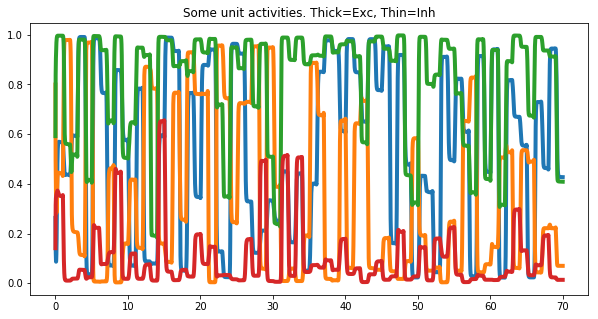

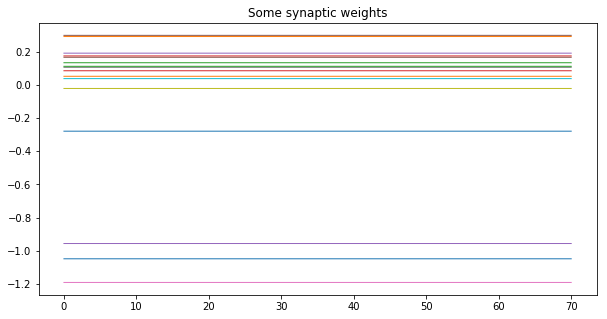

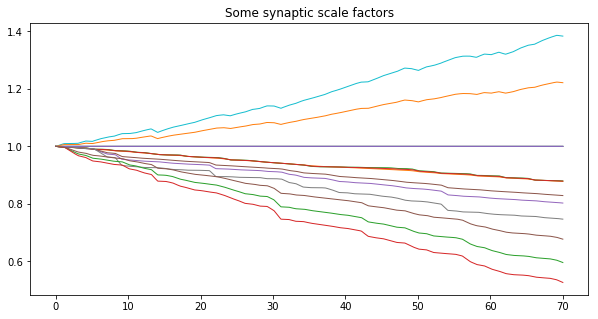

In [66]:
# basic plot 
%matplotlib inline
net_num = 11
net = mp_net_obj.nets[net_num]
L = net.layers['L']
shrp = net.layers['shrp']
I1 = net.layers['I1']
I2 = net.layers['I2']
print(L.notes)
net.basic_plot('L')

In [68]:
net.double_anim(L.e+I1.x+I2.x, slider=True, interv=10, nbins=20, thr=0.7, pdf=True)

interactive(children=(IntSlider(value=7000, description='frame', max=14000, min=1), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [25]:
# Write the analysis code a few cells above in the simulation log
f = open(log_file, mode='a')
f.write(capt3.stdout)
f.close()

NameError: name 'capt3' is not defined

In [ ]:
# Plot the highest excitatory unit activities
%matplotlib inline
n_top = 6  # how many units to plot
top_pop = np.array(L.e)  # population to visualize
top_units = net.all_activs[top_pop].sum(1).argpartition(-n_top)[-n_top:]
print(top_units)
top_act_fig = plt.figure(figsize=(18,8))
top_acts = net.all_activs[top_pop[top_units]].transpose()
plt.plot(net.all_times, top_acts)
plt.show()

In [ ]:
# Plot the lowest excitatory unit activities
n_bottom = 10  # how many units to plot
bottom_pop = np.array(L.e)  # population to visualize
bottom_units = net.all_activs[bottom_pop].sum(1).argpartition(n_bottom)[0:n_bottom-1]
print(bottom_units)
bottom_act_fig = plt.figure(figsize=(18,8))
bottom_acts = net.all_activs[bottom_pop[bottom_units]].transpose()
plt.plot(net.all_times, bottom_acts)
plt.show()

In [47]:
# Annotations for individual networks
net.annotate("Up until now removing EI plasticity would make the network unstable. But removing it with EE plasticity")
net.annotate("produces a stable network that also works great. The excessive number of inactive units is gone, ans sometimes")
net.annotate("the rate distro approaches the exponential shape, but this changes between presentations, often with somewhat")
net.annotate("flat rate distros. Overall, a good input representation with all rates present in the distribution.")
#net.annotate("Nevertheless, the active units followed the input locations coherently.")
#net.annotate("with ei_runner_mp.", make_history=False)
#net.annotate("stop growing.", make_history=False)

In [ ]:
# Visualize the connections
#ei_net.conn_anim(I1.x+I2.x, L.e, slider=False)
net.conn_anim(L.e, L.e, slider=False)

In [ ]:
# Write the configuration of the mp_net_runner object in the simulation log
f = open(log_file, mode='a')
f.write(runner.stdout)
f.close()

In [51]:
# log all networks
mp_net_obj.log() 

In [69]:
# saving
for net in mp_net_obj.nets:
    net.history.append('ei_net object being saved in container mp_ei_runner object ' + mp_net_obj.name)
F = open(mp_net_obj.name+'.pkl', 'wb')
dill.dump(mp_net_obj, F)
F.close()

In [5]:
# loading
#F = open("/media/z/data/pickles/exp_dist_sig_test4.pkl", 'rb')
#F = open("/home/z/projects/draculab/sig_ssrdc_test1.pkl", 'rb')
F = open("/home/z/projects/draculab/sig_ssrdc_test1.pkl", 'rb')
mp_net_obj = dill.load(F)

In [ ]:
mp_net_obj.code = str(runner)

In [ ]:
# Continue running after loading
mp_net_obj.run_all(save=True, log=False, save_interv=10)

In [5]:
print(mp_net_obj.code)

#~~~~~~~~~~~~ mp_net_runner object specification ~~~~~~~~~~~~

class mp_net_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self):
        """ Set parameter values and build the networks. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            input_type : The 'input_config' method, called by 'run_all', will specify the inputs sent by I1 and I2 in each
                         network, by creating custop inp_pats and inp_funcs methods. The value of input_type[i] is used in
                         input_config to know which input type will be used in network 'i'.
            inp_pats :

In [6]:
#~~~~~~~~~~~~ mp_net_runner object specification ~~~~~~~~~~~~

class mp_net_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self):
        """ Set parameter values and build the networks. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            input_type : The 'input_config' method, called by 'run_all', will specify the inputs sent by I1 and I2 in each
                         network, by creating custop inp_pats and inp_funcs methods. The value of input_type[i] is used in
                         input_config to know which input type will be used in network 'i'.
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        
        """
        self.name = 'exp_dist_sig_test4'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 12  # one per network is good
        self.n_nets = 12
        self.n_pres = [60]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.input_type = [1]*self.n_nets # specifies the values input_config assigns to inp_pats and inp_funcs
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        #F = open("/media/z/DATA/pickles/mp_net_runner_prototype.pkl", 'rb')
        #dill_obj = dill.load(F)
        #self.nets = dill_obj.nets
        
        layers =  ['L', 'shrp','I1', 'I2']  # L is the layer, shrp is for the sharpen port, I1,I2 are the input layers
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('It is seeking good configurations for the sig_ssrdc units, based on step1p2 simulations. ')
            net.annotate('made on 10/13/18 .')
            #net.annotate('10x10 in L.e and 5x5 in L.i without compensating. In here the radius of connection')
            #net.annotate('is increased, the standard tau_scale is decreased, and in the variations to the homeostatic ')
        #----------------------------------
            L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
        #----------------------------------
            L.annotate("Configuration of units in layer L.")
            L.set_param('e_pars', 'type', unit_types.sig_ssrdc)
            L.set_param('e_pars', 'slope_min', 1.7)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', .0)
            L.set_param('e_pars', 'thresh_wid', 0.4)
            L.set_param('e_pars', 'n_ports', 2)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.45, 0.45], 'slopes' : 4, 'threshs' : 0.2})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .002)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .002)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 1)
        #----------------------------------
            L.annotate("Adjusting size of e,i groups.")
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 5)
            L.set_param('i_geom', 'columns', 5)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            L.annotate("Compensating for the ratio of excitatory to inhibitory units.")
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.2, 'high' : -.01}})            
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
        #----------------------------------
            L.annotate("Setting input parameters")
            L.set_param('x_geom', 'rows', 0) # no input units in layer L
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 0)
            L.set_param('ie_syn', 'inp_ports', 0)
        #----------------------------------
            L.annotate("Using Oja input synapses")
            L.set_param('xe_syn', 'type', synapse_types.oja)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.oja)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 2.)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./20.)
            L.set_param('e_pars', 'des_act', 0.2)
        #----------------------------------
            L.annotate("Using anti_cov_pre EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.anticov_pre)
            L.set_param('ei_syn', 'lrate', .02)
        #----------------------------------
            I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 8)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 8)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
        #----------------------------------
        # Add interlayer connections
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
         #----------------------------------        
        # Configure interlayer connections
            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', 1.)
            net.set_param('I1x_Le_conn', 'weights', {'gaussian' : {'w_center': 1., 'sigma': .1}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', False)
            net.set_param('I1x_Le_syn', 'inp_ports', 1)

            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', 1.)
            net.set_param('I1x_Li_conn', 'weights', {'gaussian' : {'w_center': .3, 'sigma': 2.}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', False)

            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', 1.)
            net.set_param('I2x_Le_conn', 'weights', {'gaussian' : {'w_center': 1., 'sigma': .1}})
            net.set_param('I2x_Le_conn', 'edge_wrap', False)
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_syn', 'inp_ports', 1)

            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', 1.)
            net.set_param('I2x_Li_conn', 'weights', {'gaussian' : {'w_center': .3, 'sigma': 2.}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', False)
            
        # Now adjust networks individually
        ### network 0 is the baseline
        ### network 1
        n = 1
        L = self.nets[n].layers['L']
        L.annotate(">>> Smaller tau_scale")
        L.set_param('e_pars', 'tau_scale', .001)
        ### network 2
        n = 2
        L = self.nets[n].layers['L']
        L.annotate(">>> Smaller tau_scale, smaller Kp.")
        L.set_param('e_pars', 'tau_scale', 0.001)
        L.set_param('e_pars', 'Kp', 0.01)
        ### network 3
        n = 3
        L.annotate(">>> Smaller tau_scale, larger Kp.")
        L.set_param('e_pars', 'tau_scale', 0.001)
        L.set_param('e_pars', 'Kp', 0.05)
        ### Network 4
        n = 4
        L = self.nets[n].layers['L']
        L.annotate(">>> Larger tau_scale, smaller Kp.")
        L.set_param('e_pars', 'tau_scale', 0.005)
        L.set_param('e_pars', 'Kp', 0.01)
        ### Network 5
        n = 5
        L = self.nets[n].layers['L']
        L.annotate("Removing EI plasticity")
        L.set_param('ei_syn', 'type', synapse_types.static)
        ### Network 6
        n = 6
        L = self.nets[n].layers['L']
        L.annotate("Removing IE plasticity")
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 7
        n = 7
        L = self.nets[n].layers['L']
        L.annotate("Removing EE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        ### Network 8
        n = 8
        L = self.nets[n].layers['L']
        L.annotate("Removing EI, IE plasticity")
        L.set_param('ei_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 9
        n = 9
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, EI plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ei_syn', 'type', synapse_types.static)
        ### Network 10
        n = 10
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, IE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        ### Network 11
        n = 11
        L = self.nets[n].layers['L']
        L.annotate("Removing EE, EI, IE plasticity")
        L.set_param('ee_syn', 'type', synapse_types.static)
        L.set_param('ei_syn', 'type', synapse_types.static)
        L.set_param('ie_syn', 'type', synapse_types.static)
        
        self.build()
                      
            
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat0(self, pres, rows, columns, net_id, port=0, random=True):
    # The function that creates the input pattern at L.x
        if random:
            idx = np.random.randint(4)
        else:
            idx = pres % 4
        return (self.pat_arr0[idx, :], idx)
    
    def inp_pat1(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I1
        if random:
            idx = np.random.randint(n_pat)
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def inp_pat2(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I2
        if random:
            idx = np.random.randint(n_pat)
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def make_I1_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat1(pres, rows, columns, net_id, n_pat, random=rnd) 
    
    def make_I2_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat2(pres, rows, columns, net_id, n_pat, random=rnd)

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # patterns for L.x
        n_pat0 = 4  # number of input patterns
        self.pat_arr0 = np.zeros((4, 25)) # ei_runner.n['x'])) # array with all input patterns
        for row in range(5):
            for col in range(5):
                idx = 5*col + row
                if row == col or row+col == 4: # The X input pattern
                    self.pat_arr0[0,idx] = 1
                if row == 2 or col == 2:  # The + input pattern
                    self.pat_arr0[1,idx] = 1
                if row == 1 or row == 3:  # The = input pattern
                    self.pat_arr0[2,idx] = 1
                if col == 1 or col == 3:  # The || input pattern
                    self.pat_arr0[3,idx] = 1
        self.pat_arr0 = self.pat_arr0 / 5.
        
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            #shrp = net.layers['shrp']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units
            #pats1 = [] # here we'll store id's for the patterns presented by inp_pat1
            #pats2 = [] # here we'll store id's for the patterns presented by inp_pat2
            if self.input_type[idx] == 0:  # for sharpening units
                shrp_inp_pat = lambda p, r, c, n : (1., 1)
                inp_pat_dic = { 'I1' : self.make_I1_inp(n_pat1, True), 
                                'I2' : self.make_I2_inp(n_pat2, True), 
                                'shrp' : shrp_inp_pat }
                inp_fun_dic = {'shrp' : self.set_shrp_fun }
            elif self.input_type[idx] == 1: # for non-sharpening units
                inp_pat_dic = { #'L' : self.inp_pat0,
                                'I1' : self.make_I1_inp(n_pat1, True), 
                                'I2' : self.make_I2_inp(n_pat2, True) } 
                inp_fun_dic = {}
            else:
                raise ValueError('Invalid input type for network ' + str(idx))
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)

    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base 
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of mp_net_runner object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(n_nets)]
            self.nets = pool.map(self.run_net, args)
            # you can run just a few nets for debugging purposes...
            #selected = [0, 1, 2] #, 1, 2, 3, 6, 8, 9, 10, 11, 12, 14, 15]
            #sel_nets = [self.nets[n] for n in selected]
            #args = [(n, self.n_pres[n]) for n in selected]
            #sel_nets = pool.map(self.run_net, args)
            #for i,n in enumerate(selected):
            #    self.nets[n] = sel_nets[i]
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
                                
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
# Continue running after loading
mp_net_obj.run_all(save=True, log=False, save_interv=10)

In [ ]:
# mean activity given the rate distribution
c = 3
a = np.exp(-c)
b = 1-a
mean = (b/c**3)*(1. - (c+1.)*a)
print(mean)

n_points = 1000
r = np.linspace(0.,1.,n_points)
pdf = (b/c)*np.exp(-c*r)
mean2 = np.dot(r,pdf)/n_points
print(mean2)

In [59]:
for n in range(11):
    mp_net_obj.nets[n+1].log(log_file, False)

In [57]:
log_file

'./logs/mp_net_07-17-18.txt'